In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import time

# 自定义 MAPE 和 RAE 计算函数
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def relative_absolute_error(y_true, y_pred):
    y_mean = np.mean(y_true)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - y_mean))

# 加载数据
def load_data(file_path, target_column):
    df = pd.read_excel(file_path)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X = pd.get_dummies(X)  # 处理类别变量
    return X, y

# 划分数据集
def split_data(X, y):
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# 模型评估函数，增加推理时间和吞吐量的计算
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, param_grid=None):
    if param_grid:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)
    
    # 测量推理时间
    start_time = time.time()
    test_preds = best_model.predict(X_test)
    end_time = time.time()
    
    # 计算推理时间
    inference_time = end_time - start_time
    
    # 计算吞吐量 (样本数 / 推理时间)
    throughput = len(X_test) / inference_time

    # 计算评估指标
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_preds)
    mape = mean_absolute_percentage_error(y_test, test_preds)
    rae = relative_absolute_error(y_test, test_preds)
    r2 = r2_score(y_test, test_preds)

    # 输出结果
    print(f"{model_name} Performance on Test Set:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"Relative Absolute Error (RAE): {rae}")
    print(f"R-squared: {r2}")
    
    # 输出推理时间和吞吐量
    print(f"Inference Time: {inference_time} seconds")
    print(f"Throughput: {throughput} samples/second")

    return test_preds




In [6]:
# 数据路径和目标列
data_path = 'D:/疏散数据汇总/疏散时间.xlsx'  # 请根据你的路径调整
target_column = '95%的人疏散时间'

# 加载并划分数据
X, y = load_data(data_path, target_column)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)


随机森林

In [7]:
# 定义模型和参数
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = [
    {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 4]}
]

# 评估随机森林模型
rf_preds = evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test, 'RandomForest', rf_param_grid)


Best parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest Performance on Test Set:
Mean Squared Error (MSE): 6194.335179597436
Root Mean Squared Error (RMSE): 78.70409887418467
Mean Absolute Error (MAE): 50.570577363764734
Mean Absolute Percentage Error (MAPE): 10.195240914665089%
Relative Absolute Error (RAE): 0.34751893300408193
R-squared: 0.8392954708189643
Inference Time: 0.1234281063079834 seconds
Throughput: 5250.019783849564 samples/second


xgboost

In [8]:
# 定义模型和参数
xgb_model = XGBRegressor(random_state=42)
xgb_param_grid = [
    {'n_estimators': [100, 200], 'max_depth': [3, 4], 'learning_rate': [0.05, 0.1]}
]

# 评估XGBoost模型
xgb_preds = evaluate_model(xgb_model, X_train, y_train, X_val, y_val, X_test, y_test, 'XGBoost', xgb_param_grid)


Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
XGBoost Performance on Test Set:
Mean Squared Error (MSE): 5756.087348515334
Root Mean Squared Error (RMSE): 75.86888261016722
Mean Absolute Error (MAE): 46.32759125650649
Mean Absolute Percentage Error (MAPE): 9.26776447471411%
Relative Absolute Error (RAE): 0.31836130654197903
R-squared: 0.8506652803815196
Inference Time: 0.007988929748535156 seconds
Throughput: 81112.24161394294 samples/second


LightGBM

In [9]:
# 定义模型和参数
lgbm_model = LGBMRegressor(random_state=42)
lgbm_param_grid = [
    {'n_estimators': [100, 200], 'num_leaves': [20, 31], 'learning_rate': [0.05, 0.1]}
]

# 评估LightGBM模型
lgbm_preds = evaluate_model(lgbm_model, X_train, y_train, X_val, y_val, X_test, y_test, 'LightGBM', lgbm_param_grid)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 11
[LightGBM] [Info] Start training from score 454.481269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 11
[LightGBM] [Info] Start training from score 458.946447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 11
[LightGBM] [Info] Start training

GBDT

In [10]:
# 定义模型和参数
gbdt_model = GradientBoostingRegressor(random_state=42)
gbdt_param_grid = [
    {'n_estimators': [100, 200], 'max_depth': [3, 4], 'learning_rate': [0.05, 0.1]}
]

# 评估GBDT模型
gbdt_preds = evaluate_model(gbdt_model, X_train, y_train, X_val, y_val, X_test, y_test, 'GBDT', gbdt_param_grid)


Best parameters for GBDT: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
GBDT Performance on Test Set:
Mean Squared Error (MSE): 5846.603913056651
Root Mean Squared Error (RMSE): 76.46308856603068
Mean Absolute Error (MAE): 46.53149021361382
Mean Absolute Percentage Error (MAPE): 9.296327461396144%
Relative Absolute Error (RAE): 0.31976249181033944
R-squared: 0.8483169376674201
Inference Time: 0.005000114440917969 seconds
Throughput: 129597.03375929811 samples/second


AdaBoost

In [11]:
# 定义模型和参数
ada_model = AdaBoostRegressor(random_state=42)
ada_param_grid = [
    {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
]

# 评估AdaBoost模型
ada_preds = evaluate_model(ada_model, X_train, y_train, X_val, y_val, X_test, y_test, 'AdaBoost', ada_param_grid)


Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoost Performance on Test Set:
Mean Squared Error (MSE): 10938.105055933303
Root Mean Squared Error (RMSE): 104.58539599740159
Mean Absolute Error (MAE): 80.10553500174541
Mean Absolute Percentage Error (MAPE): 19.94019676845557%
Relative Absolute Error (RAE): 0.5504819502312933
R-squared: 0.7162241028002128
Inference Time: 0.029002666473388672 seconds
Throughput: 22342.77322723312 samples/second


SVM

In [12]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# 定义模型和参数（缩小网格）
svm_model = SVR()
svm_param_grid = [
    {'C': [1, 10], 'kernel': ['linear'], 'epsilon': [0.1]}
]

# 评估SVM模型
svm_preds = evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, 'SVM', svm_param_grid)


Best parameters for SVM: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
SVM Performance on Test Set:
Mean Squared Error (MSE): 16476.545901298967
Root Mean Squared Error (RMSE): 128.36099836515362
Mean Absolute Error (MAE): 80.51658331084076
Mean Absolute Percentage Error (MAPE): 16.147511149599772%
Relative Absolute Error (RAE): 0.5533066573482878
R-squared: 0.5725359582866396
Inference Time: 0.014110803604125977 seconds
Throughput: 45922.260572780266 samples/second


神经网络

In [13]:
# 定义模型和参数
nn_model = MLPRegressor(random_state=42)
nn_param_grid = [
    {'hidden_layer_sizes': [(50, 50), (100,)], 'activation': ['relu', 'tanh'], 'learning_rate_init': [0.001, 0.01]}
]

# 评估神经网络模型
nn_preds = evaluate_model(nn_model, X_train, y_train, X_val, y_val, X_test, y_test, 'NeuralNetwork', nn_param_grid)


C:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer

Best parameters for NeuralNetwork: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}
NeuralNetwork Performance on Test Set:
Mean Squared Error (MSE): 9878.51824916728
Root Mean Squared Error (RMSE): 99.39073522802455
Mean Absolute Error (MAE): 65.1509608460547
Mean Absolute Percentage Error (MAPE): 13.953020205501218%
Relative Absolute Error (RAE): 0.44771473013940144
R-squared: 0.7437138000753345
Inference Time: 0.003002166748046875 seconds
Throughput: 215844.10673443455 samples/second


决策树

In [14]:
# 定义模型和参数
dt_model = DecisionTreeRegressor(random_state=42)
dt_param_grid = [
    {'max_depth': [10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 4]}
]

# 评估决策树模型
dt_preds = evaluate_model(dt_model, X_train, y_train, X_val, y_val, X_test, y_test, 'DecisionTree', dt_param_grid)


Best parameters for DecisionTree: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
DecisionTree Performance on Test Set:
Mean Squared Error (MSE): 8906.934589862864
Root Mean Squared Error (RMSE): 94.37655741688644
Mean Absolute Error (MAE): 62.2150004962345
Mean Absolute Percentage Error (MAPE): 12.782409787232849%
Relative Absolute Error (RAE): 0.4275389310621521
R-squared: 0.7689203622004812
Inference Time: 0.002009153366088867 seconds
Throughput: 322523.91028835886 samples/second


线性回归

In [15]:
# 定义线性回归模型
lr_model = LinearRegression()

# 评估线性回归模型
lr_preds = evaluate_model(lr_model, X_train, y_train, X_val, y_val, X_test, y_test, 'LinearRegression')


LinearRegression Performance on Test Set:
Mean Squared Error (MSE): 15221.791355174573
Root Mean Squared Error (RMSE): 123.37662402244023
Mean Absolute Error (MAE): 83.84618237727578
Mean Absolute Percentage Error (MAPE): 18.096212461305605%
Relative Absolute Error (RAE): 0.5761875255372276
R-squared: 0.6050890463463319
Inference Time: 0.0019838809967041016 seconds
Throughput: 326632.4951327965 samples/second


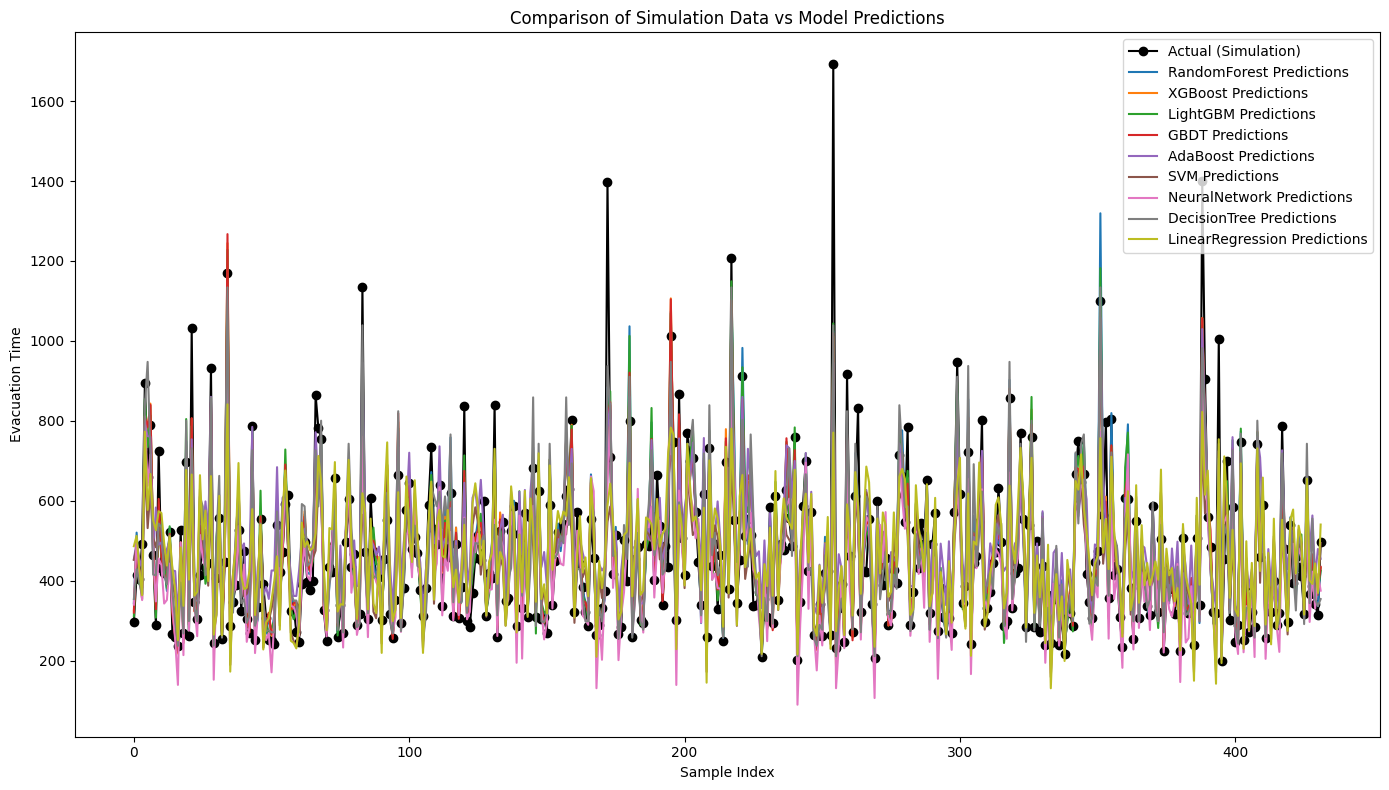

预测与仿真数据的对比结果已保存到 Excel 文件


In [17]:
# 创建一个 DataFrame 来保存仿真数据和模型预测数据
comparison_df = pd.DataFrame({
    'Actual': y_test
})

# 将索引重置，方便可视化
comparison_df.reset_index(drop=True, inplace=True)

# 添加各模型的预测结果
comparison_df['RandomForest Predictions'] = rf_preds
comparison_df['XGBoost Predictions'] = xgb_preds
comparison_df['LightGBM Predictions'] = lgbm_preds
comparison_df['GBDT Predictions'] = gbdt_preds
comparison_df['AdaBoost Predictions'] = ada_preds
comparison_df['SVM Predictions'] = svm_preds
comparison_df['NeuralNetwork Predictions'] = nn_preds
comparison_df['DecisionTree Predictions'] = dt_preds
comparison_df['LinearRegression Predictions'] = lr_preds

# 可视化对比
def plot_comparison(data, model_names):
    plt.figure(figsize=(14, 8))
    plt.plot(data['Actual'], label='Actual (Simulation)', color='black', linestyle='-', marker='o')

    for model in model_names:
        plt.plot(data[model], label=model)

    plt.title('Comparison of Simulation Data vs Model Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Evacuation Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 绘制对比图
plot_comparison(comparison_df, [f'{model_name} Predictions' for model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'GBDT', 'AdaBoost', 'SVM', 'NeuralNetwork', 'DecisionTree', 'LinearRegression']])

# 保存预测与仿真数据对比结果到 Excel
comparison_df.to_excel(r'D:\疏散数据汇总\预测与仿真对比结果_多模型_验证集.xlsx', index=False)
print("预测与仿真数据的对比结果已保存到 Excel 文件")
